In [1]:
import numpy as np
import os
import sys
sys.path.append('../')
import cv2
from utils import load_train_val, load_test, visualize_data_sample
from copy import deepcopy
import sklearn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from keras.api.models import Model
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy
from keras.api.utils import to_categorical
import random
import matplotlib.style
import seaborn as sns

In [2]:
MULTI_CLASS = False
SHUFFLE = True

In [3]:
(x_train, y_train), (x_val, y_val) = load_train_val(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

In [4]:
(x_test, y_test) = load_test(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

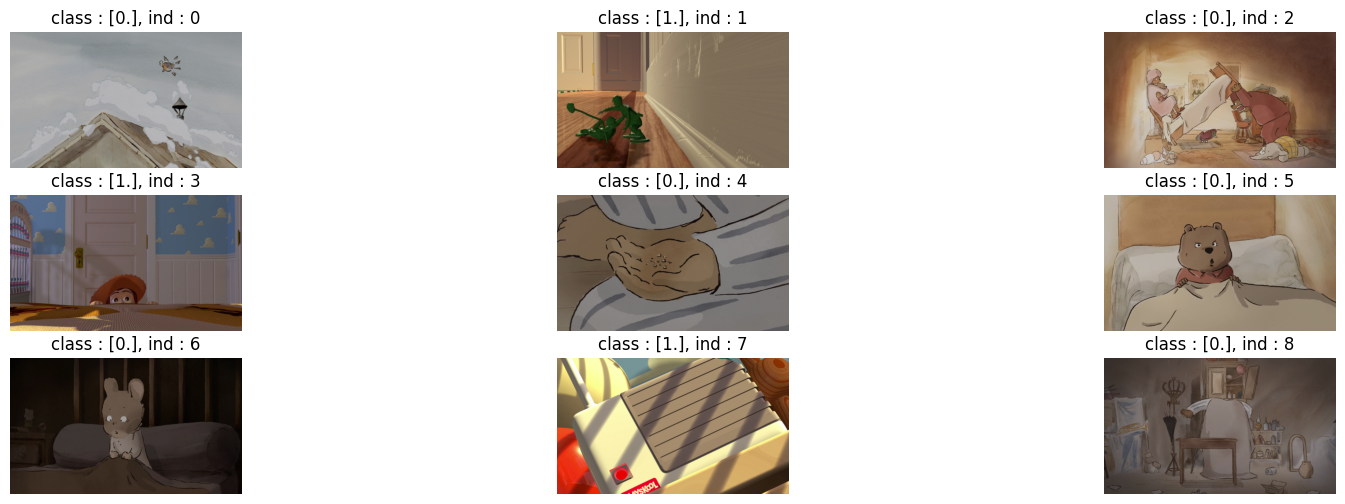

In [7]:
visualize_data_sample(x=x_val, y=y_val)

In [8]:
input = Input((270, 460, 3))

x = Conv2D(filters=8, kernel_size=3, strides=1)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=16, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(16)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(1)(x)
output = Activation('sigmoid')(x)

model_bin = Model(input, output)

In [9]:
model_bin.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 270, 460, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 268, 458, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 268, 458, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 268, 458, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 134, 229, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 66, 114, 16)    │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 66, 114, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 66, 114, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 57, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30096)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       481,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,121 (1.84 MB)

 Trainable params: 483,041 (1.84 MB)

 Non-trainable params: 80 (320.00 B)

In [11]:
opt = Adam(learning_rate=0.005)
model_bin.compile(optimizer=opt, loss=binary_crossentropy, metrics=['accuracy'])

In [12]:
history = model_bin.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.8112 - loss: 0.3935 - val_accuracy: 0.5000 - val_loss: 0.9475
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.9101 - loss: 0.2403 - val_accuracy: 0.5000 - val_loss: 1.7244
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9284 - loss: 0.1962 - val_accuracy: 0.5000 - val_loss: 1.9275
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9623 - loss: 0.1365 - val_accuracy: 0.5400 - val_loss: 0.9548
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9688 - loss: 0.1213 - val_accuracy: 0.6900 - val_loss: 0.5664
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - accuracy: 0.9611 - loss: 0.1185 - val_accuracy: 0.8100 - val_loss: 0.5014
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9622 - loss: 0.1278 - val_accuracy: 0.9050 - val_loss: 0.1958
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9677 - loss: 0.0842 - val_accu

In [13]:
evaluation = model_bin.evaluate(x=x_test, y=y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7634 - loss: 1.0869


In [19]:
with open('./models/evaluation_bin.npy', 'wb') as f:
    np.save(f, evaluation)

In [20]:
with open('./models/history_bin.npy', 'wb') as f:
    np.save(f, history)

In [22]:
model_bin.save('./models/model_bin.keras')

In [59]:
plt.style.use('default')

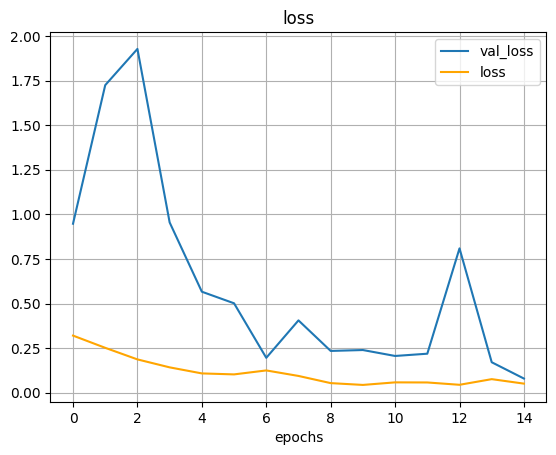

In [14]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('loss')
plt.grid(True)

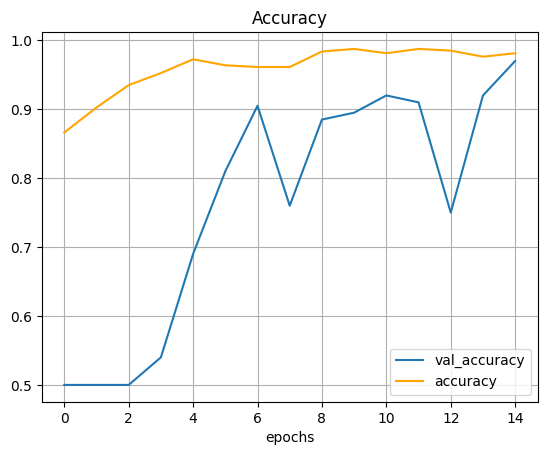

In [15]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('Accuracy')
plt.grid(True)

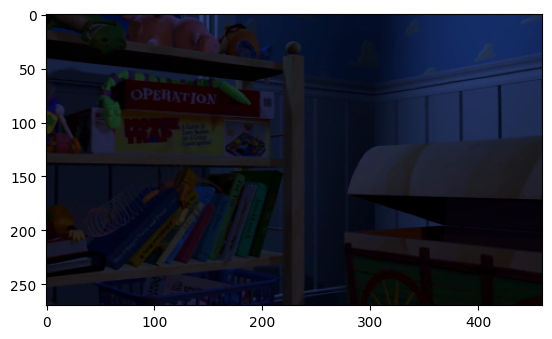

In [63]:
plt.imshow(x_test[5,:,:,::-1])

In [16]:
y_pred  = (model_bin.predict(x_test) >= 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


In [17]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

Text(50.722222222222214, 0.5, 'True classes')

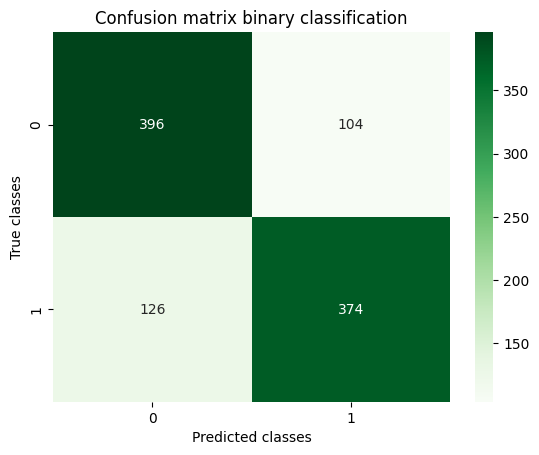

In [18]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens'), plt.title('Confusion matrix binary classification')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')

In [50]:
matplotlib.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']